# Descarga de datos de producción agrícola mensual desde la página del SIAP.

El Servicio de Información Agroalimentaria y Pesquera (SIAP) del gobierno de México nos proporciona información de la producción de cultivos con las variables:

- Superficie sembrada
- Superficie cosechada
- Superficie siniestrada
- Producción obtenida
- Rendimiento

En diferentes años, meses, entidades, distritos, municipios, ciclos y modalidades.

Para más información visite el siguiente enlace: https://www.gob.mx/siap/acciones-y-programas/produccion-agricola-33119

Los datos son descargados del siguiente enlace: https://nube.siap.gob.mx/avance_agricola/"

En esta primera iteración del proyecto, no descargaremos todos los datos. Descargaremos un subconjunto, muy reducido, como ejemplo. Esto lo hacemos a la espera de reunirnos con el cliente para determinar la información que él necesita específicamente, como por ejemplo, qué cultivos y modalidades. Por ahora, sabemos que el cliente desea los datos desglosados por municipio desde el año 2020 hasta la fecha actual.

### Librerías

In [69]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

import json
import requests
import os
import logging
from datetime import datetime


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Obteneción de IDs

Para obtener los datos del SIAP, lo haremos a través de una API. El problema es que no está documentada y no conocemos los IDs de las opciones. Estas opciones se muestran en la siguiente imagen:

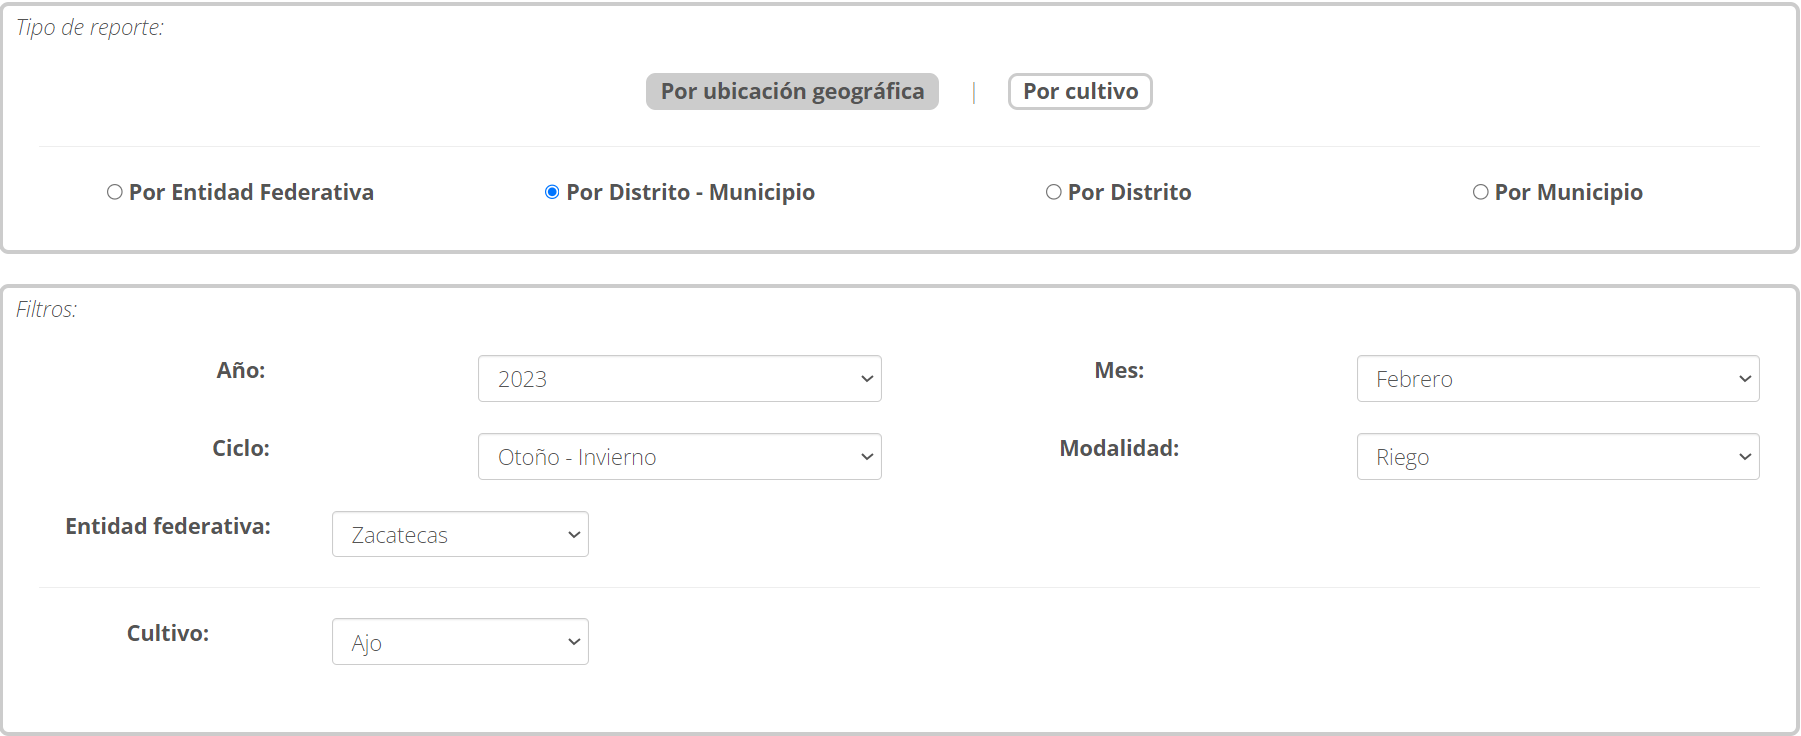

Por lo tanto, primero obtendremos los IDs de las opciones, las cuales son dinámicas. Esto significa que al seleccionar una opción, las otras cambiarán en función de las elecciones en los otros recuadros.

Para obtener los IDs y, posteriormente, los datos, en el recuadro "Tipo de reporte" seleccionaremos la opción "por ubicación geográfica" y "Por Distrito - Municipio". Al elegir estas opciones, las consultas estarán desglosadas por entidad federativa, distrito y municipio, que es la forma en que el cliente lo desea.

In [70]:
def collapse_nested_dict(d, parent_key='', sep='_', exclude_keys=None):
    """
    Función recursiva para colapsar un diccionario anidado en un diccionario
    no anidado. Se pueden excluir llaves específicas.
    """
    
    if exclude_keys is None:
        exclude_keys = []

    items = []
    for k, v in d.items():
        if k not in exclude_keys:
            # Si el valor de la llave es un diccionario, otra vez llamamos a la función
            if isinstance(v, dict):
                items.extend(collapse_nested_dict(v, k, sep=sep, exclude_keys=exclude_keys).items())
            # Si ya no es diccionario, lo agregamos a nuestra lista items
            else:
                items.append((f"{parent_key}{sep}{k}", v))
    return dict(items)

In [71]:
# Configuramos Selenium
options = webdriver.ChromeOptions()
options.add_argument("--headless")  
options.add_argument("--disable-gpu")
driver = webdriver.Chrome(options=options)


# Mandamos una petición a la página y esperamos a que 
# se cargue correctamente la página
url = "https://nube.siap.gob.mx/avance_agricola/"
driver.get(url)
driver.implicitly_wait(10)
wait = WebDriverWait(driver, 10)
wait.until(EC.invisibility_of_element_located((By.CLASS_NAME, "blockUI blockOverlay")))

# Hacemos click en la opción con ID "opcionDDRMpio2", esta opción
# hace que nos despliegue los resultados por ubicación geografica
opcionDDRMpio2_radio = driver.find_element(By.ID, 'opcionDDRMpio2')
if not opcionDDRMpio2_radio.is_selected():
    opcionDDRMpio2_radio.click()


# Relocalizamos el botón después de que cambie la página
opcionDDRMpio2_radio = driver.find_element(By.ID, 'opcionDDRMpio2')

# Buscamos elementos con clase "form-control", estos elementos
# contienen los IDs
select_elements = driver.find_elements(By.CLASS_NAME, 'form-control')

# Obtenmos los IDs de todas las combinaciones al seleccionar opciones de la página
result_dict = {}
for select_element in select_elements:

    select_id = select_element.get_attribute("id")

    # Creamos un objeto Select para interactuar
    select = Select(select_element)

    # Obtenemos todas las opciones que aparecen al seleccionar el elemento,
    # algunos elementos no tienen IDs y solo contienen "--", estos los
    # saltamos
    select_options = {opt.text: opt.get_attribute("value") for opt 
                      in select.options if opt.get_attribute("value") != "--"}

    # Iteramos por cada una de las opciones
    select_data = {}
    for option_text, option_value in select_options.items():
        try:
            # Seleccionamos la opción
            select.select_by_value(option_value)

            # Relocalizamos el elemento después del cambio de contenido de la página
            select_element = driver.find_element(By.ID, select_id)

            # Otra vez buscamos los elementos con classe "form-control"
            dependent_select_elements = driver.find_elements(By.CLASS_NAME, 'form-control')

            # Por último, volvemos a iterar por cada opción nueva al
            # seleccionar una opción diferente
            option_data = {}
            for dependent_select_element in dependent_select_elements:

                dependent_select_id = dependent_select_element.get_attribute("id")
                dependent_select = Select(dependent_select_element)
                dependent_select_options = {opt.text: opt.get_attribute("value") for opt 
                                            in dependent_select.options if opt.get_attribute("value") != "--"}
             
                # Diccionario con las opciones y sus IDs, cuando hacemos click en una opción
                option_data[dependent_select_id] = dependent_select_options

            # Diccionario con las opciones y sus IDs, cuando hacemos click en una opción
            # por cada opción
            select_data[option_text] = option_data

        except Exception as e:
            # print(f"Exception: {e}")
            continue

    # Diccionario con las opciones y sus IDs, cuando hacemos click en una opción por cada 
    # opción de las opciones que se pueden escoger
    result_dict[select_id] = select_data

# Cerramos el controlador de navegador de Selenium
driver.quit()

In [72]:
result_dict

{'anioagric': {'2023': {'anioagric': {'2023': '2023',
    '2022': '2022',
    '2021': '2021',
    '2020': '2020',
    '2019': '2019',
    '2018': '2018'},
   'mesagric': {'Agosto': '8',
    'Julio': '7',
    'Junio': '6',
    'Mayo': '5',
    'Abril': '4',
    'Marzo': '3',
    'Febrero': '2',
    'Enero': '1'},
   'cicloProd': {'Otoño - Invierno': '1',
    'Primavera - Verano': '2',
    'Perennes': '3',
    'Año Agrícola (OI + PV)': '4',
    'Ciclicos - Perennes': '5'},
   'modalidad': {'Riego': '1', 'Temporal': '2', 'Riego + Temporal': '3'},
   'entidad': {'Nacional': '0',
    'Aguascalientes': '1',
    'Baja California': '2',
    'Baja California Sur': '3',
    'Campeche': '4',
    'Coahuila': '5',
    'Colima': '6',
    'Chiapas': '7',
    'Chihuahua': '8',
    'Ciudad de México': '9',
    'Durango': '10',
    'Guanajuato': '11',
    'Guerrero': '12',
    'Hidalgo': '13',
    'Jalisco': '14',
    'México': '15',
    'Michoacán': '16',
    'Morelos': '17',
    'Nayarit': '18',
    '

Como podemos ver, hay dos IDs ocultos, `unidMed` y `variedad`. Dado que no son de nuestro interés, los eliminaremos, y del diccionario anidado, solo nos quedaremos con los elementos únicos.

In [82]:
exclude_keys = ['unidMed', 'variedad']
flat_dict = collapse_nested_dict(result_dict, exclude_keys=exclude_keys)
print(f"Elementos únicos: {len(flat_dict)}")

Elementos únicos: 2646


Guardamos los IDs en un archivo json.

In [74]:
with open("IDsSIAP.json", "w", encoding="utf-8") as outfile:
    json.dump(flat_dict, outfile, ensure_ascii=False, indent=4)

Al final, agruparemos cada opción con los valores que puede tomar.

In [75]:
# Leemos el archivo
with open('IDsSIAP.json', 'r', encoding='utf-8') as file:
    IDs_dict = json.load(file)


# Obtenemos las IDs de cada opción
options = [key for key in result_dict.keys() if key not in exclude_keys]

# Las agrupamos en un diccionario
options_dict = {}
for option in options:
    options_temp = {}

    for key, value in IDs_dict.items():
        if option in key:
            options_temp[key] = value

    options_dict[option] = options_temp

options_dict

{'anioagric': {'anioagric_2023': '2023',
  'anioagric_2022': '2022',
  'anioagric_2021': '2021',
  'anioagric_2020': '2020',
  'anioagric_2019': '2019',
  'anioagric_2018': '2018'},
 'mesagric': {'mesagric_Agosto': '8',
  'mesagric_Julio': '7',
  'mesagric_Junio': '6',
  'mesagric_Mayo': '5',
  'mesagric_Abril': '4',
  'mesagric_Marzo': '3',
  'mesagric_Febrero': '2',
  'mesagric_Enero': '1',
  'mesagric_Diciembre': '12',
  'mesagric_Noviembre': '11',
  'mesagric_Octubre': '10',
  'mesagric_Septiembre': '9'},
 'cicloProd': {'cicloProd_Otoño - Invierno': '1',
  'cicloProd_Primavera - Verano': '2',
  'cicloProd_Perennes': '3',
  'cicloProd_Año Agrícola (OI + PV)': '4',
  'cicloProd_Ciclicos - Perennes': '5'},
 'modalidad': {'modalidad_Riego': '1',
  'modalidad_Temporal': '2',
  'modalidad_Riego + Temporal': '3'},
 'entidad': {'entidad_Nacional': '0',
  'entidad_Aguascalientes': '1',
  'entidad_Baja California': '2',
  'entidad_Baja California Sur': '3',
  'entidad_Campeche': '4',
  'enti

# Descarga de los datos

Ya que tenemos los IDs podemos empezar con la descarga. Para obtener datos desde la página, primero elegimos un valor para cada una de las opciones que se ven en la primera imagen. Al hacer esto, la página nos da la siguiente tabla:

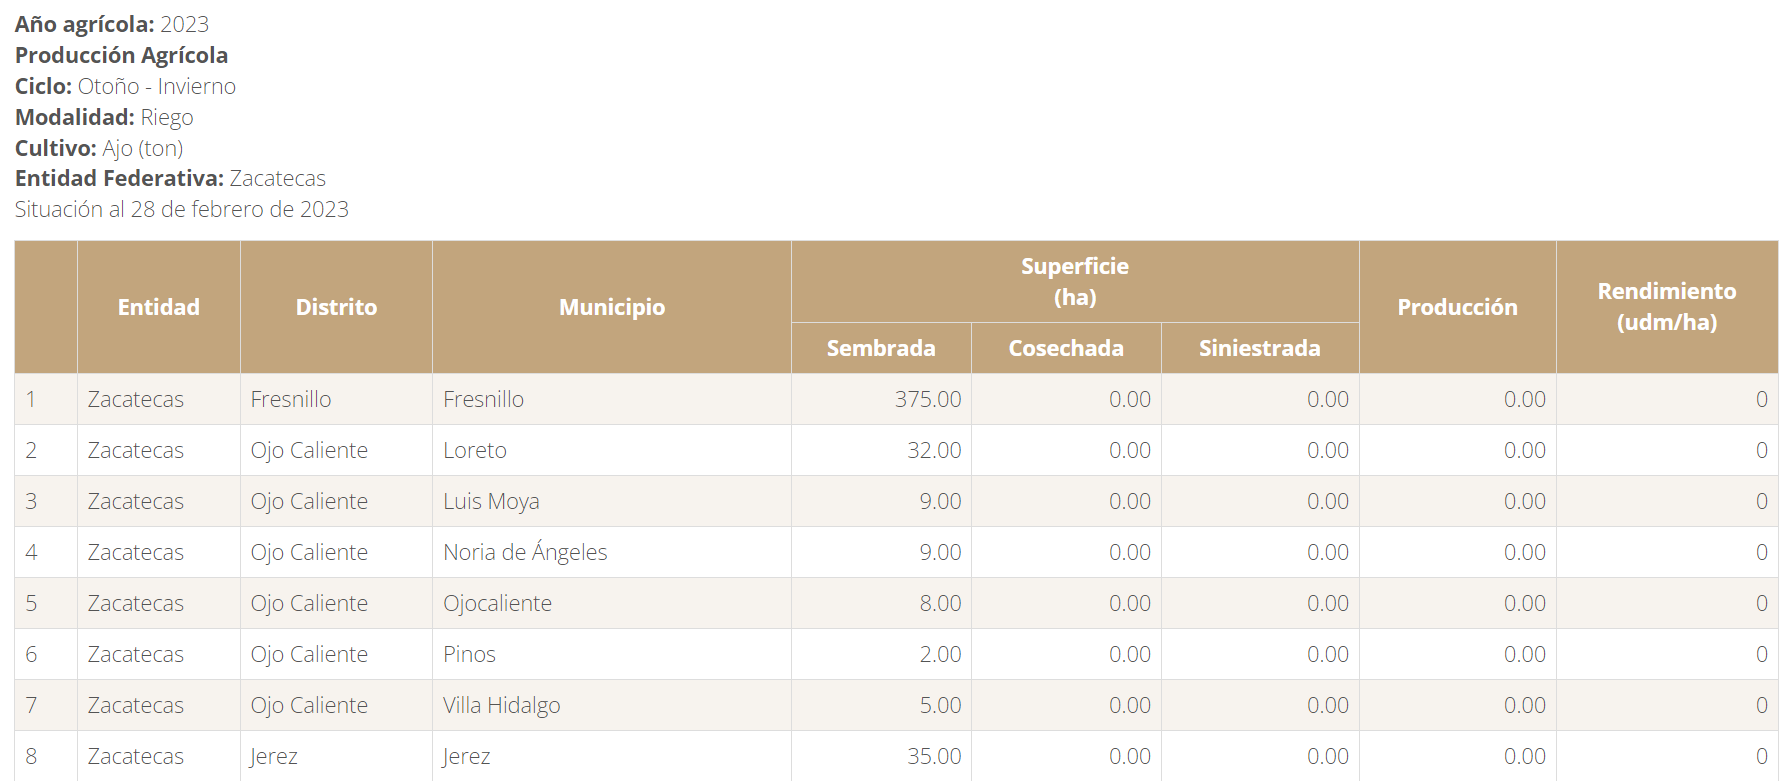

Ahora, descargaremos cada consulta en un archivo csv. Lo haremos para las opciones dentro del diccionario `request_dict`.

In [76]:
request_dict = {
  'anio': ['2023'],
  'mes': ['Enero', 'Febrero'],
  'ciclo': ['Otoño - Invierno'],
  'modalidad': ['Riego'],
  'cultivo': ['Ajo', 'Ajonjolí']
}

In [77]:
def fetch_response_SIAP(url, payload, headers= None):
    """
    Función para hacer una consulta a la página del SIPA
    y que nos devuelva, solamente, la tabla en xml con los
    datos.
    """
    try:
        response = requests.request("POST", url, data=payload, headers=headers, verify=False)
        response.encoding = 'ISO-8859-1'
        response.raise_for_status()  # Si no se hizo la consulta levantamos una excepción

        # Extraemos el xml y nos quedamos con solo la tabla de datos
        xml_data = response.text

        cdata_start = xml_data.find("<![CDATA[") + len("<![CDATA[")
        cdata_end = xml_data.find("]]>")
        html_content = xml_data[cdata_start:cdata_end]

        soup = BeautifulSoup(html_content, "html.parser")
        
        table = soup.find("table", id="Resultados-reporte")

        return table
        
    except requests.exceptions.RequestException as e:
        return None

In [78]:
def tidy_df_SIAP(table_xml, meta_info_names):
    """
    Función para convertir la tabla de datos en xml 
    del SIPA en un data frame tidy.
    """
    df = pd.DataFrame()
    if table_xml:

        # Cada columna esta dada por un elemento tr
        table_rows = table_xml.find_all("tr")

        # Extraemos los títulos de las columnas
        header_row1 = table_rows[0]
        header_row2 = table_rows[1]

        main_headers = [th.text.strip() for th in header_row1.find_all("th")]
        main_headers[0] = "índice"
        sub_headers = [th.text.strip() for th in header_row2.find_all("th")]

        # Creamos una lista con los ítulos de forma tidy
        combined_headers = []

        for main in main_headers:
            if main == 'Superficie(ha)':
                combined_headers.extend([f"{main}_{sub}" for sub in sub_headers])
            else:
                combined_headers.append(main)

        # Extraemos los datos, a partir del segundo renglón porque los primeros son 
        # los títulos y no incluimos el último porque es el total de las columnas
        table_data = []
        for row in table_rows[2:-1]:
            row_data = [cell.text.strip() for cell in row.find_all(["th", "td"])]
            table_data.append(row_data)

        # Creamos el data frame y agregamos una columna por cada opción
        df = pd.DataFrame(table_data, columns=combined_headers)
        df = df.set_index(df.columns[0])

        df_columns = ["Año", "Mes", "Ciclo", "Modalidad", "cultivo"] + df.columns.tolist()
        
        df[df_columns[0]] = meta_info_names[0].replace(" ", "")
        df[df_columns[1]] = meta_info_names[1].replace(" ", "")
        df[df_columns[2]] = meta_info_names[2].replace(" ", "")
        df[df_columns[3]] = meta_info_names[3].replace(" ", "")
        df[df_columns[4]] = meta_info_names[4].replace(" ", "")

        df = df[df_columns]

        return df
    else:
        raise Exception

Información sobre las descargas se encontrará en el archivo **descargasSIAP.log**.

In [79]:
# Configuración del logging
log_filename = "descargasSIAP.log"
log_format = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(filename=log_filename, level=logging.INFO, 
                    format=log_format, encoding="utf-8", force=True)

info = '''
El Servicio de Información Agroalimentaria y Pesquera (SIAP) del gobierno de México, nos proporciona
información de la producción de cultivos con las variables: 
- Superficie sembrada
- Superficie cosechada
- Superficie siniestrada
- Producción obtenida 
- Rendimiento 

En diferentes años, meses, entidades, distritos, municipios, ciclos y modalidades. 
Para más información visite el siguiente enlace: https://www.gob.mx/siap/acciones-y-programas/produccion-agricola-33119
Los datos son descargados del siguiente enlace: https://nube.siap.gob.mx/avance_agricola/

Archivos descargados:
'''
logging.info(info)

In [80]:
url = "https://nube.siap.gob.mx/avance_agricola/"

df_number = 0

# Directorio donde guardar los csv
directory = 'datosSIAP'
if not os.path.exists(directory):
    os.makedirs(directory)


# Hacemos las consultas y los guardamos
for anio in request_dict['anio']:

  for mes in request_dict['mes']:

    for ciclo in request_dict['ciclo']:

      for modalidad in request_dict['modalidad']:
        
        for cultivo in request_dict['cultivo']:    

          payload = {'xajax': 'reporte', # Para obtener la tabla
          'xajaxr': '1696449941927', # Timestamp UNIX
          'xajaxargs[]': [
              '1', # 1: Por ubicación geografica, 2: Por cultivo
              options_dict['anioagric'][f"anioagric_{anio}"], #ID  Año
              options_dict['cicloProd'][f"cicloProd_{ciclo}"], # ID Ciclo
              options_dict['modalidad'][f"modalidad_{modalidad}"], # ID Modalidad
              '0', # ID Estado (0: Nacional)
              '--',
              '--', 
              options_dict['cultivo'][f"cultivo_{cultivo}"], # ID Cultivo
              '200201', # ID uniMed?
              '0', # ID variedad?
              '3', # 0: Por Distrito, 1: Por Municipio, 2: Por entidad federativa, 3: Por Distrito - Municipio
              'undefined',
              'undefined',
              'undefined',
              options_dict['mesagric'][f"mesagric_{mes}"] # ID mes
              ]
          }

          try:

            xml = fetch_response_SIAP(url, payload)

            df = tidy_df_SIAP(xml, [anio, mes, ciclo, modalidad, cultivo])

            df.to_csv(os.path.join(directory,(f"{anio.replace(' ', '')}_{mes.replace(' ', '')}" +
                      f"_{ciclo.replace(' ', '')}_{modalidad.replace(' ', '')}" +
                      f"_{cultivo.replace(' ', '')}.csv")), index=False)

            logging.info(f"Se descargó la información: Año={anio}, Mes={mes}," +
                        f"Ciclo={ciclo}, Modalidad={modalidad}, Cultivo={cultivo}")

            df_number += 1
          except Exception as e:
            # print(f"Failed: {str(e)}")
            continue


print(f"Número de archivos csv creados: {df_number}")

c:\Users\Victor Minjares\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nube.siap.gob.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Victor Minjares\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nube.siap.gob.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Victor Minjares\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nube.siap.gob.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.i

Número de archivos csv creados: 4


In [81]:
# Cerramos el sistema logging
logging.shutdown()